# 构建一个逻辑回归分类器来识别猫

## 逻辑回归原理介绍
逻辑回归主要用来处理二分类问题，目的是预测当前被观察的对象属于哪个组。它会给你提供一个离散的二进制(0或者1)输出结果。逻辑回归的实现过程主要包括构造预测函数与代价函数，选择优化方法更新参数以及决策函数阈值的选取三部分。
#### 1. 构造预测函数
对于二分类问题，通常选择sigmoid函数作为基础逻辑函数，sigmoid函数的表达式为：
$$sigmoid(z^{(i)}) = \frac{1}{1+e^{-z^{(i)}}}\tag{1}$$
对于单个输入 $x^{(i)}$：
$$z^{(i)} = w^T x^{(i)} + b \tag{2}$$
可得到预测函数$\hat{y}^{(i)}$为：
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{3}$$
对应的损失函数$ \mathcal{L}(a^{(i)}, y^{(i)}) $为：
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{4}$$
然后通过对所有训练样例求和来计算代价函数：
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{5}$$
对于逻辑回归的多分类问题，通常选择softmax函数作为基础逻辑函数,这里不做介绍。
#### 2. 选择优化方法更新参数
计算出代价函数后，需要选择优化方法来最小化代价函数，以得到合适的参数w和b。这里选择梯度下降法作为优化方法。梯度下降法的过程为：首先执行前向传播和反向传播，然后根据反向传播得到的各个参数的偏导数，进行参数的更新。     

**前向传播**  
对于输入$X$，逻辑回归的预测值为：
$$A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})\tag{6}$$
通过已知的训练数据与得到的预测值，可得到代价函数：
$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})\tag{7}$$
**反向传播**
$$ dW = \frac{\partial J}{\partial W} = \frac{1}{m}X(A-Y)^T\tag{8}$$
$$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{9}$$
**更新参数**
$$ W = W - \alpha*dW\tag{10}$$
$$ b = b - \alpha*db\tag{11}$$
其中，$\alpha$为学习速率。
#### 3. 决策函数阈值的选取
求得参数W与b的值后，可得逻辑回归的预测值为：
$$\hat{y}^{(i)} = sigmoid({ W^T x^{(i)} + b})\tag{12}$$
对应的决策函数为：
$$ y_p^{(i)} = 1,\ if\ \ \hat{y}^{(i)}>0.5\tag{13}$$
$$y_p^{(i)} = 0,\ if\ \ \hat{y}^{(i)}=<0.5\tag{14}$$
选择0.5作为阈值是一个一般的做法，实际应用时特定的情况可以选择不同阈值，如果对正例的判别准确性要求高，可以选择阈值大一些，对正例的召回要求高，则可以选择阈值小一些。

## 学习目标
- 构建学习算法的通用框架，主要包括：
  - 数据预处理
  - 初始化参数
  - 计算代价函数及其梯度
  - 使用优化算法（梯度下降法）

## 第一步：数据预处理

### 导入库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

E:\ruanjian\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 导入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 将数据集转换为矢量

In [4]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

### 数据标准化

In [5]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 第二步：初始化参数

In [6]:
def initialize_with_zeros(dim):
    """
    此函数为w创建一个形状为（dim，1）的零向量，并将b初始化为0。
    
    输入：
    dim -- w向量的大小 
    
    输出:
    w -- 初始化的向量
    b -- 初始化的偏差
    """
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

## 第三步：计算代价函数及其梯度

In [7]:
def propagate(w, b, X, Y):
    """
    实现前向传播的代价函数及反向传播的梯度

    输入:
    w -- 权重, 一个numpy数组，大小为(图片长度 * 图片高度 * 3, 1)
    b -- 偏差, 一个标量
    X -- 训练数据，大小为 (图片长度 * 图片高度 * 3 , 样本数量)
    Y -- 真实"标签"向量，大小为(1, 样本数量)

    输出:
    cost -- 逻辑回归的负对数似然代价函数
    dw -- 相对于w的损失梯度，因此与w的形状相同
    db -- 相对于b的损失梯度，因此与b的形状相同
    """
    
    m = X.shape[1]
    
    # 前向传播
    Z = np.dot(w.T,X)+b
    A = 1 / (1 + np.exp(-Z))                          
    cost = np.sum(np.multiply(Y,np.log(A)) + np.multiply(1-Y,np.log(1-A))) / (-m)
    
    # 反向传播
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum(A-Y)/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## 第四步：使用优化算法(梯度下降法）

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b
    
    输入:
    w -- 权重, 一个numpy数组，大小为(图片长度 * 图片高度 * 3, 1)
    b -- 偏差, 一个标量
    X -- 训练数据，大小为 (图片长度 * 图片高度 * 3 , 样本数量)
    Y -- 真实"标签"向量，大小为(1, 样本数量)
    num_iterations -- 优化循环的迭代次数
    learning_rate -- 梯度下降更新规则的学习率
    print_cost -- 是否每100步打印一次丢失
    
    输出:
    params -- 存储权重w和偏见b的字典
    grads -- 存储权重梯度相对于代价函数偏导数的字典
    costs -- 在优化期间计算的所有损失的列表，这将用于绘制学习曲线。
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # 成本和梯度计算
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        # 更新参数
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # 记录成本
        if i % 100 == 0:
            costs.append(cost)
        
        # 每100次训练迭代打印成本
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## 第五步：模型训练与测试

### 定义预测函数

In [9]:
def predict(w, b, X):
    '''
    使用学习的逻辑回归参数（w，b）预测标签是0还是1
    
    输入:
    w -- w -- 权重, 一个numpy数组，大小为(图片长度 * 图片高度 * 3, 1)
    b -- 偏差, 一个标量
    X -- 训练数据，大小为 (图片长度 * 图片高度 * 3 , 样本数量)
    
    输出:
    Y_prediction -- 包含X中示例的所有预测（0/1）的numpy数组（向量）
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # 计算向量“A”预测猫出现在图片中的概率
    A = 1 / (1 + np.exp(-(np.dot(w.T,X)+b)))
    # 将概率A[0，i]转换为实际预测p[0，i]
    for i in range(A.shape[1]):
        if A[0,i]<=0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
        pass
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

### 定义模型训练函数

In [16]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    通过调用前面实现的函数来构建逻辑回归模型
    
    Arguments:
    X_train -- 由numpy数组表示的训练集，大小为 (图片长度 * 图片高度 * 3，训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    X_test -- 由numpy数组表示的测试集，大小为（图片长度 * 图片高度 * 3，测试样本数）
    Y_test -- 由numpy数组（向量）表示的测试标签，大小为 (1, 测试样本数)
    num_iterations -- 超参数，表示优化参数的迭代次数
    learning_rate -- 超参数，在优化算法更新规则中使用的学习率
    print_cost -- 设置为true时，以每100次迭代打印成本
    
    Returns:
    d -- 包含模型信息的字典。
    """
    
    # 初始化参数
    w, b = initialize_with_zeros(X_train.shape[0])

    # 梯度下降
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # 从字典“parameters”中检索参数w和b
    w = parameters["w"]
    b = parameters["b"]
    
    # 预测测试/训练集
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # 打印训练/测试集的预测准确率
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### 模型训练

In [17]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


### 测试

y = 1, you predicted that it is a "cat" picture.


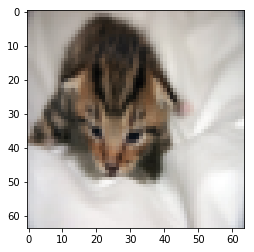

In [18]:
num_px = train_set_x_orig.shape[1]
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

### 绘制学习曲线

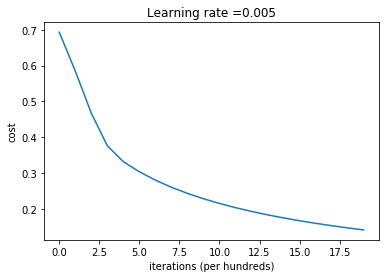

In [19]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**解读**：可以看到：成本在下降。它表明正在学习参数。但是，如果在训练集上进一步训练模型并增加迭代次数，可能会看到训练集精度上升，但测试集精度下降。这称为过度拟合。

### 学习率的选择
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;为了让梯度下降工作，必须明智地选择学习率。学习率(learning_rates)——确定我们更新参数的速度。如果学习率太大，我们可能会“超调”最佳值。同样，如果它太小，我们将需要太多的迭代来收敛到最佳值。这就是为什么使用良好调整的学习率至关重要。

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



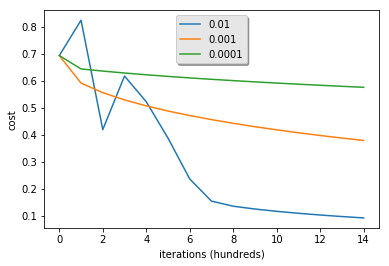

In [20]:
# 将模型的学习曲线与几种学习率选择进行比较
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**解释**：
- 不同的学习率会产生不同的成本，从而产生不同的预测结果 如果学习率太大（0.01），则成本可能上下波动。它甚至可能发散。
- 较低的成本并不意味着更好的模型。你必须检查是否有可能过度拟合。当训练精度远高于测试精度时，就会发生这种情况。 
- 在深度学习中，通常建议： 选择更好地降低代价函数的学习率。 
- 如果模型过度拟合，可以使用其他技术来减少过度拟合。

### 使用自己的图像进行测试

E:\ruanjian\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
E:\ruanjian\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


y = 0.0, your algorithm predicts a "non-cat" picture.


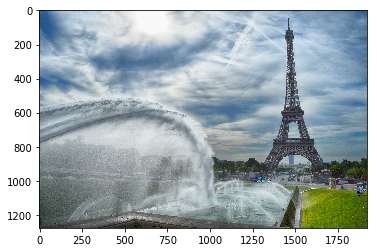

In [21]:
my_image = "my_image.jpg"   # change this to the name of your image file 
# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")